Super Convergence

**A. Target**
1. Write a code which 
> 1. Uses this new ResNet Architecture for Cifar10:
>> 1. PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
>> 2. Layer1 -
>>> 1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
>>> 2. R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
>>> 3. Add(X, R1)
>>3. Layer 2 -
>>> 1. Conv 3x3 [256k]
>>> 2. MaxPooling2D
>>> 3. BN
>>> 4. ReLU
>> 4. Layer 3 -
>>> 1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
>>> 2. R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
>>> 3. Add(X, R2)
>> 5. MaxPooling with Kernel Size 4
>> 6. FC Layer 
>> 7. SoftMax
> 2. Uses One Cycle Policy such that:
>> 1. Total Epochs = 24
>> 2. Max at Epoch = 5
>> 3. LRMIN = FIND
>> 4. LRMAX = FIND
>> 5. NO Annihilation
>> 3. Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
>>4. Batch size = 512
>>5. Target Accuracy: 90%. 


**B. Results**
1. Parameters: 6,573,120
2. Best Training Accuracy in 24 epochs: 98.81%
3. Best Test Accuracy in 50 epochs: 93.22 %

**C. Analysis**

I have implemented the david net and applied the required image augmentations. I used the LR finder to find the max learning rate with test range between .0001 to .02 and with 400 iteration (nearly 5 epochs with batch size of 512 while total 50000 images in train set). I found max LR to be .03. With max LR as 0.03 and min LR as Max Lr/ 10 = 0.003, with one cycle approach, we could train the network to reach above 90% accuracy in less than 24 epocs


# Mount Drive and Unzip data

In [35]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [36]:
import sys
folder = '/content/gdrive/My Drive/EVA5'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/EVA5/Models"
sys.path.append(folder)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import OneCycleLR

import albumentations as A
from collections import Sequence
import numpy as np

from   torch.utils.data import Dataset
import torch.nn.functional as F

In [38]:
rm -r TSAI_EVA5

rm: cannot remove 'TSAI_EVA5': No such file or directory


In [39]:
!git clone https://github.com/SachinDangayach/TSAI_EVA5.git 

Cloning into 'TSAI_EVA5'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 383 (delta 256), reused 247 (delta 120), pack-reused 0
Receiving objects: 100% (383/383), 5.21 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [40]:
from TSAI_EVA5.session11.dataset import session11_dataset as dataset
from TSAI_EVA5.session11.models import session11 as models
from TSAI_EVA5.session11.models import session11_train_model as train
from TSAI_EVA5.session11.models import session11_test_model as test
from TSAI_EVA5.session9.utils import session9_utils as utils
from TSAI_EVA5.session11.utils import session11_lr_test as lr_test
from TSAI_EVA5.session10.utils import session10_lr_finder as lr_finder
from TSAI_EVA5.session9.utils import session9_view_gradcam as grad_cam

## Extract, Load and Transform Data

In [41]:
# Calculate Ture Mean and STD
norm_mean,norm_std = dataset.cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
# Extract Datasets
train_set,test_set = dataset.get_datasets()
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


In [43]:
# Get train and test transform
train_transform, test_transform = dataset.get_album_transforms(norm_mean,norm_std)

In [44]:
# transform the data
train_set,test_set = dataset.trasnform_datasets(train_set, test_set, train_transform, test_transform)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

CUDA Available? True


### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 20 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


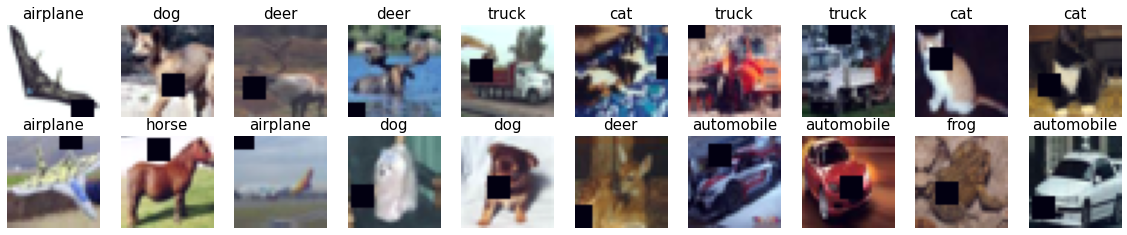

In [45]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 20)

## Import Model and show model summary

In [46]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# LR Range Test

Learning Rate = 0.0001 epoch=0 Train Accuracy=19.25: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]
Learning Rate = 0.0001 epoch=1 Train Accuracy=30.19: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
Learning Rate = 0.0001 epoch=2 Train Accuracy=35.47: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
Learning Rate = 0.0001 epoch=3 Train Accuracy=39.70: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
Learning Rate = 0.0001 epoch=4 Train Accuracy=42.85: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
Learning Rate = 0.02009 epoch=0 Train Accuracy=16.62: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
Learning Rate = 0.02009 epoch=1 Train Accuracy=38.67: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
Learning Rate = 0.02009 epoch=2 Train Accuracy=58.66: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
Learning Rate = 0.02009 epoch=3 Train Accuracy=67.58: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
Learning Rate = 0.02009 epoch=4 Train Accuracy=72.44: 100%|██████████| 98/98 [00:23<00:

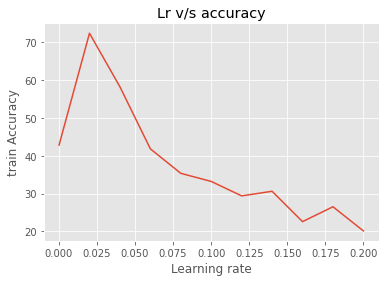

In [47]:
max_lr = .2
min_lr = 0.0001
steps = 10
iterations= 400
criterion = nn.NLLLoss()
lr_test.LR_test(max_lr, min_lr,device,iterations,steps,model,criterion,train_loader,momemtum = 0.9,weight_decay=0.05, plot= True )

# One Cycle LR ( Max LR = 0.03)

In [13]:
model = models.Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9 ,weight_decay=0.005 ) 
scheduler = OneCycleLR(optimizer, max_lr =0.03, total_steps=None, epochs=24, steps_per_epoch=len(train_loader), 
                       pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

## Train and Test Model

In [14]:
train_acc = []
train_loss = []
test_acc = []
test_loss = []
LR = []
EPOCHS = 24
best_acc = 0
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     LR.append(optimizer.param_groups[0]['lr'])
     train.train(model, device, train_loader, criterion, optimizer, epoch, train_loss, train_acc, scheduler)
     test.test(model, device, test_loader, test_loss, test_acc)
     
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA5/bestmodel.pt")


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.003


Loss=1.3011075258255005 Batch_id=97 Train Accuracy=42.84: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]



Test set: Average loss: 1.4043, Test Accuracy: 5297/10000 (52.97%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.009753721438343577


Loss=0.8493312001228333 Batch_id=97 Train Accuracy=61.41: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]



Test set: Average loss: 1.2288, Test Accuracy: 6056/10000 (60.56%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.01650744287668715


Loss=0.8337138891220093 Batch_id=97 Train Accuracy=70.34: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.8535, Test Accuracy: 7147/10000 (71.47%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.023261164315030728


Loss=0.7493352293968201 Batch_id=97 Train Accuracy=75.92: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.8882, Test Accuracy: 7161/10000 (71.61%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.029997023299115563


Loss=0.47059065103530884 Batch_id=97 Train Accuracy=77.52: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.7167, Test Accuracy: 7540/10000 (75.40%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.02864648308302913


Loss=0.4953800439834595 Batch_id=97 Train Accuracy=83.43: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.4758, Test Accuracy: 8361/10000 (83.61%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.027295942866942695


Loss=0.45855098962783813 Batch_id=97 Train Accuracy=85.38: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]



Test set: Average loss: 0.4827, Test Accuracy: 8382/10000 (83.82%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.02594540265085626


Loss=0.39698174595832825 Batch_id=97 Train Accuracy=87.25: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.4252, Test Accuracy: 8540/10000 (85.40%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 9 LR: 0.024594862434769826


Loss=0.39212945103645325 Batch_id=97 Train Accuracy=88.28: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.4113, Test Accuracy: 8611/10000 (86.11%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 10 LR: 0.023244322218683392


Loss=0.3105631172657013 Batch_id=97 Train Accuracy=89.59: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4089, Test Accuracy: 8600/10000 (86.00%)

EPOCH: 11 LR: 0.021893782002596958


Loss=0.268763929605484 Batch_id=97 Train Accuracy=90.79: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.3519, Test Accuracy: 8800/10000 (88.00%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 12 LR: 0.020543241786510524


Loss=0.2730405628681183 Batch_id=97 Train Accuracy=91.48: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4165, Test Accuracy: 8551/10000 (85.51%)

EPOCH: 13 LR: 0.01919270157042409


Loss=0.22966687381267548 Batch_id=97 Train Accuracy=92.38: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3537, Test Accuracy: 8781/10000 (87.81%)

EPOCH: 14 LR: 0.01784216135433765


Loss=0.19743196666240692 Batch_id=97 Train Accuracy=92.93: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3637, Test Accuracy: 8768/10000 (87.68%)

EPOCH: 15 LR: 0.01649162113825122


Loss=0.18430861830711365 Batch_id=97 Train Accuracy=93.60: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.3579, Test Accuracy: 8805/10000 (88.05%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 16 LR: 0.015141080922164785


Loss=0.18133684992790222 Batch_id=97 Train Accuracy=94.17: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3622, Test Accuracy: 8775/10000 (87.75%)

EPOCH: 17 LR: 0.013790540706078349


Loss=0.13899114727973938 Batch_id=97 Train Accuracy=94.95: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.3188, Test Accuracy: 8951/10000 (89.51%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 18 LR: 0.012440000489991915


Loss=0.17220830917358398 Batch_id=97 Train Accuracy=95.63: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.2783, Test Accuracy: 9098/10000 (90.98%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 19 LR: 0.01108946027390548


Loss=0.15111015737056732 Batch_id=97 Train Accuracy=96.15: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.2636, Test Accuracy: 9132/10000 (91.32%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 20 LR: 0.009738920057819043


Loss=0.12075139582157135 Batch_id=97 Train Accuracy=96.91: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.2614, Test Accuracy: 9141/10000 (91.41%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 21 LR: 0.008388379841732609


Loss=0.07386793196201324 Batch_id=97 Train Accuracy=97.40: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.2452, Test Accuracy: 9160/10000 (91.60%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 22 LR: 0.007037839625646174


Loss=0.08682537078857422 Batch_id=97 Train Accuracy=97.88: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.2346, Test Accuracy: 9211/10000 (92.11%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 23 LR: 0.00568729940955974


Loss=0.05771483853459358 Batch_id=97 Train Accuracy=98.46: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.2247, Test Accuracy: 9259/10000 (92.59%)

accuracy increased, Saving model....


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 24 LR: 0.004336759193473306


Loss=0.0601670928299427 Batch_id=97 Train Accuracy=98.81: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]



Test set: Average loss: 0.2047, Test Accuracy: 9322/10000 (93.22%)

accuracy increased, Saving model....


#  Validation accuracies and Loss change curves

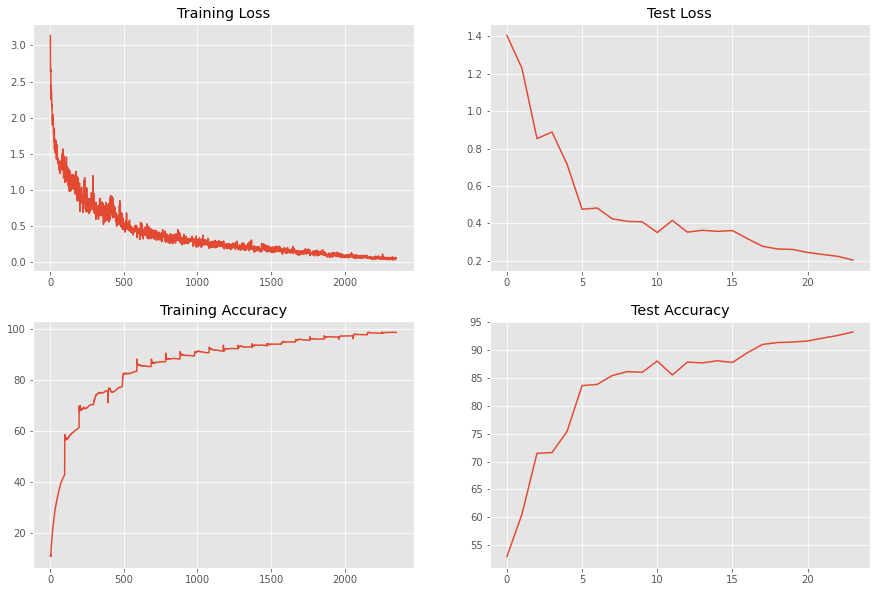

In [16]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

# Learning Rate Change Vs Epoch

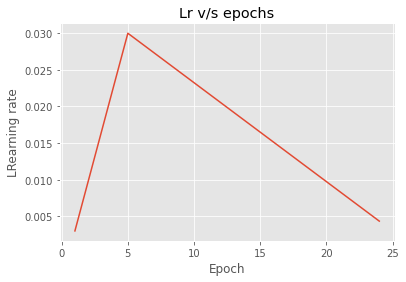

In [21]:
import matplotlib.pyplot as plt
epochs = []
for i in range(24):
  epochs.append(i+1)

plt.plot(epochs,LR)
plt.ylabel('LRearning rate')
plt.xlabel('Epoch')
plt.title("Lr v/s epochs")
plt.show()

## Display misclassified images

In [17]:
images, act_lbl, pred_lbl = utils.get_images_by_results(model,test_loader,number_of_images = 30, mode= 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

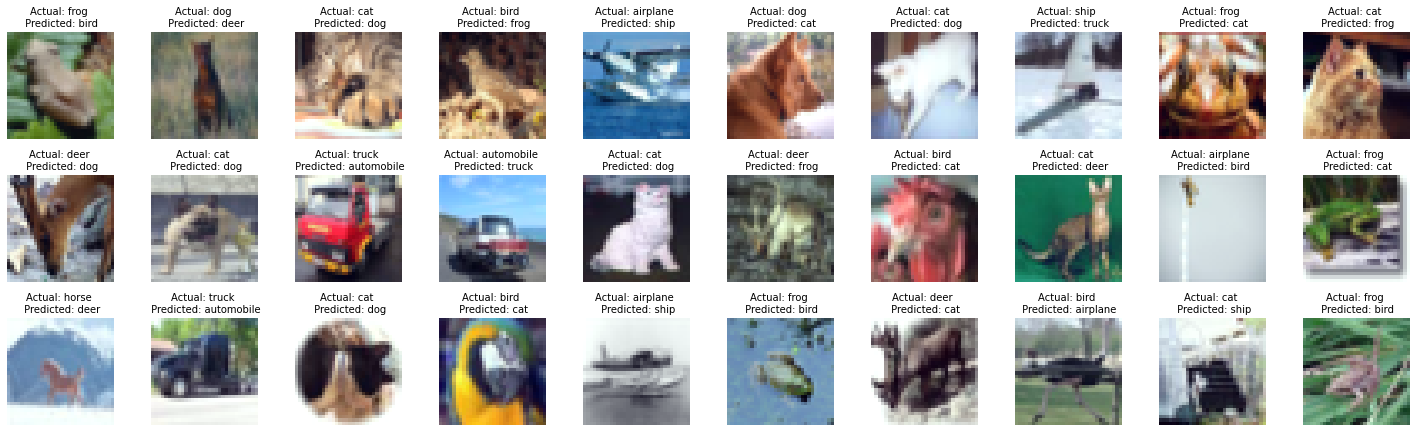

In [18]:
utils.show_images(images, act_lbl, pred_lbl, classes, num_of_images = 30)